## Laboratorio de Analitica con DataBricks
**Hecho por: Juan Sebastián Clavijo Martínez (jclavijomartinez@gmail.com)**<br />
TEMA: INTRODUCCION A MACHINE LEARNING(APRENDIZJE DE MAQUINA)<br />
Fecha: 14-08-2023<br />
Notas: modelos de clasificacion de la bib. Scikit-Learn
Dataset: Investigacion sobe caso de impagos de clietes de taiwan

## Clasificador **BAGGIN**<br />
Es un metaestimador de conjuntos que ajusta los clasificadores base a subconjuntos aleatorios del conjunto de datos original, para posteriormente agregar sus predicciones individuales (ya sea por votacion o promedio) y formar una prediccion final.

Un metaestimador de este tipo puede utilizarse normalmente para reducir la varianza de un estimador de cja negra (p.e: un arbol de desicion), introduciendo la aleatoreidad en su procediemiento de construccion y convirtiendolo en un conjunto.

## Clasificador **Random Forest**<br />
Un bosque aleatorio es un metaestimador que ajusta varios clasificadores de arboles de desicion en varias submuestras de conjunto de datos y utiliza el promedio para mejorar la presicion predictiva y controlar el sobreajuste. El tamaño de la submuestra se controla con el parametro *max_samples* si *bootstrap=True* (por defecto), de lo contrario se usa todo el conjunto de datos para construir cada arbol

## Clasificador **gradient boosting**<br />
Este algortimo construye un model aditivo por etapas y permite optimizar funciones de pérdida diferenciales arbitrarias. En cada etapa se ajustan arboles de regresion de *n_clases* sobre el gradiente negativo de la func. de pérdida, p.e: la pérdida log binaria o multiclase. La clasifiación binaria es un caso especial en el que solo se induce a un único arbol de regresion.

In [1]:
#importar las bibliotecas pertinentes
import pandas as pd #tratamiento de datos en un dataframe
import numpy as np #numerical python
import seaborn as sns #biblioteca versatil para estadistica y visualizacion
import matplotlib.pyplot as plt #biblioteca para vizualizacion de datos
#para clasificar 
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#para modelar
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler
#(esto fue del 28-08)
import time ##para medir rendimiento de los modelos 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
# 18-09
%pip install nltk
from nltk.tokenize import RegexpTokenizer

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [2]:
#preparacion de los datos
url = 'https://raw.githubusercontent.com/corredor-john/ExploratoryDataAnalisys/main/Varios/datos_credit_card.csv'
df_cards = pd.read_csv(url)
df_cards.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
#se renombran la colunmas
df_cards.rename(columns={'PAY_0':'PAY_1','default payment next month':'default'},inplace=True)
df_cards.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

##**Identificacion de datos**

LIMIT_BAL: cant. de credito (NT USD): incluye ambos, personal y cred. familiar<br />
Sex: gender (1 = male, 2= Female)<br />
Education. 1.Grad School, 2.Bachiller, 3. uni, 4.Otros<br />
MARRIAGE: 1.married, 2.single, 3.otro<br />
AGE: Edad (años)<br />
PAY_1...PAY6: Historico de pagos.Se traza los regs. de pago mansuales (desde abr a sep de 2005) 1.Estado de repago en ago ... 6.estado de repago en abr<br />
BILL_AMT1 ... BILL_AMT6: Cant. de facturas (estado). X12. Cant de facturas a sep/05<br />
PAY_AMT1 ... PAY_AMT6: Cant. de pagos previos (USD)<br />
default : positiva clase: def. | pos. clase: pay<br />

#Construccion de modelos usando todas las caracteristicas

In [4]:
variable_target = 'default'
X = df_cards.drop(variable_target, axis = 1)
names_Features = X.columns
#se hace un tratameinto de normalizacion de datos a partir del escalador robusto de sklearn
robusto_escalador = RobustScaler()
X = robusto_escalador.fit_transform(X)
y = df_cards[variable_target]
#se divide en datos para entrenaamiento y prueba con train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=55,stratify=y)

In [5]:
#se crea una funcion para el calculo de la matriz de confusion
def CMatrix(CM,labels = ['PAY','default']):
    df = pd.Dataframe(data=CM,index=labels,columns=labels)
    df.index.name = 'TRUE'
    df.columns.name = 'Prediction'
    df.loc['TOTAL'] = df.sum(axis=1)
    return df

## Laboratorio de Analitica con DataBricks
**Hecho por: Juan Sebastián Clavijo Martínez**<br />
TEMA: Clasificacion de productos electronicos en 4 categorias, basandose en la desc. disp. en las plataformas de comercio electronico: <br />
Electronics, household, books, clothing & Accesories <br />
### PASOS:<br />
- analisis exploratorio de datos se comparan las distr. del numero de caracteres, en num de palabras y la longitud media de palabras de las descripciones de productos de diferentes categorías <br />
- Normalización de textos: técnicas y desc. de productos <br />
- TF-IDF: Vectorizador en las desc. de productos normalizados para la vectorización de textos se realiza ajuste de hiperparametros para los clasificadores de ML<br />
- Proceso de tratamiento en la conv. minúscula y sustitución de contracciones sobre la desc. de datos en crudo<br />
- <br />
Fecha: 28-08-2023<br />
Notas: 

In [6]:
#se trae el url
url = "https://raw.githubusercontent.com/corredor-john/ExploratoryDataAnalisys/main/Varios/ecommerce-NLP.csv"

# se hace el DF
data = pd.read_csv(url,names = ['label','description'])
#data = data[['label','description']]
#se visualiza
data.head()

,label,description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [7]:
##cuenta de datos null, etc.
desaparecidos = len(data)-len(data.dropna())
Cantidad = len(data)
print('Cantidad de obsev. con datos NaN',desaparecidos)
print('Cantidad de datos duplicados', data.duplicated().sum())
##se eliminan los datos Null y Duplicados
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
#Se reinicia el indice por los elementos eliminados
data.reset_index(drop = True, inplace = True)

Cantidad de obsev. con datos NaN 0
Cantidad de datos duplicados 14831


In [8]:
#vals. unicos de la col 'labels'
data['label'].unique()

array(['Household', 'Books', 'Clothing & Accessories'], dtype=object)

In [9]:
#se hacen cambios a las siguientes cats:
#Electronics = 0
#Household = 1 
#Books = 2
#Clothing and accesories = 3
label_dict={'Electronics':0,'Household':1, 'Books':2, 'Clothing & Accessories':3}
data.replace({'label':label_dict},inplace = True)
print('dimension del df',data.shape)

dimension del df (18044, 2)


In [10]:
#Explorando Data Analisis 
# frecuencia de clases 
# numero de chars
# Numero de palabras
# Promedio de longitud de palabras
# Se divide el conjunto de datos en funcion de las clases, para observar los distintos atributos textuales de las clases


#Se dividen los datos según 'label'
data_E = data[data['label']==0] #electronics
data_H = data[data['label']==1] #Household 
data_B = data[data['label']==2] #Books
data_C = data[data['label']==3] #C&A

In [11]:
#Frecuencia de clases
valores = np.array([len(data_E),len(data_H),len(data_B),len(data_C)])
labels =['Electronics','Household', 'Books', 'Clothing & Accessories']
# Se vizualizan las clases con Plotly
title="Comparacion de frecuencia de clases"
figura = go.Figure(data = [go.Pie(values = valores,labels = labels, hole=0.5)])
title="Comparacion de frecuencia de clases"
figura.update_layout(height=450,width =450,title = title)
figura.show()

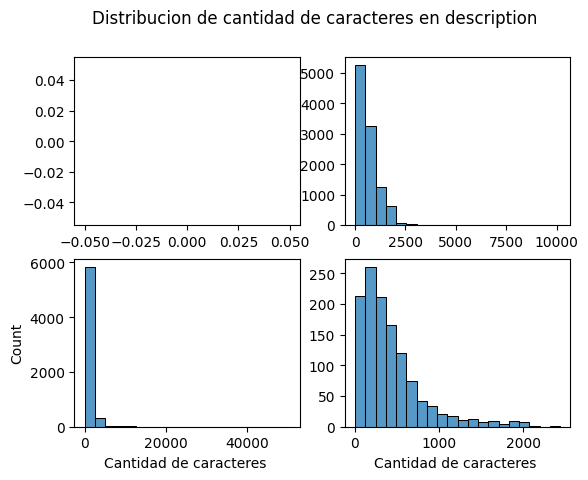

In [12]:
#numero de caracteres
data_E_char = data_E['description'].str.len()
data_H_char = data_H['description'].str.len()
data_B_char = data_B['description'].str.len()
data_C_char = data_C['description'].str.len()
#se visualiza la contidad de chars
fig,ax=plt.subplots(2,2)
sns.histplot(x=data_E_char, bins = 20,ax = ax [0,0])
sns.histplot(x=data_H_char, bins = 20,ax = ax [0,1])
sns.histplot(x=data_B_char, bins = 20,ax = ax [1,0])
sns.histplot(x=data_C_char, bins = 20,ax = ax [1,1])
#Se itera para graficar la matriz
fig.suptitle("Distribucion de cantidad de caracteres en description")
for i in range(4):
    ax[i//2,i%2].set_xlabel(" ") if i//2 == 0 else ax[i//2,i%2].set_xlabel("Cantidad de caracteres ")
    if i%2 != 0 : ax[i//2,i%2].set_ylabel(" ")


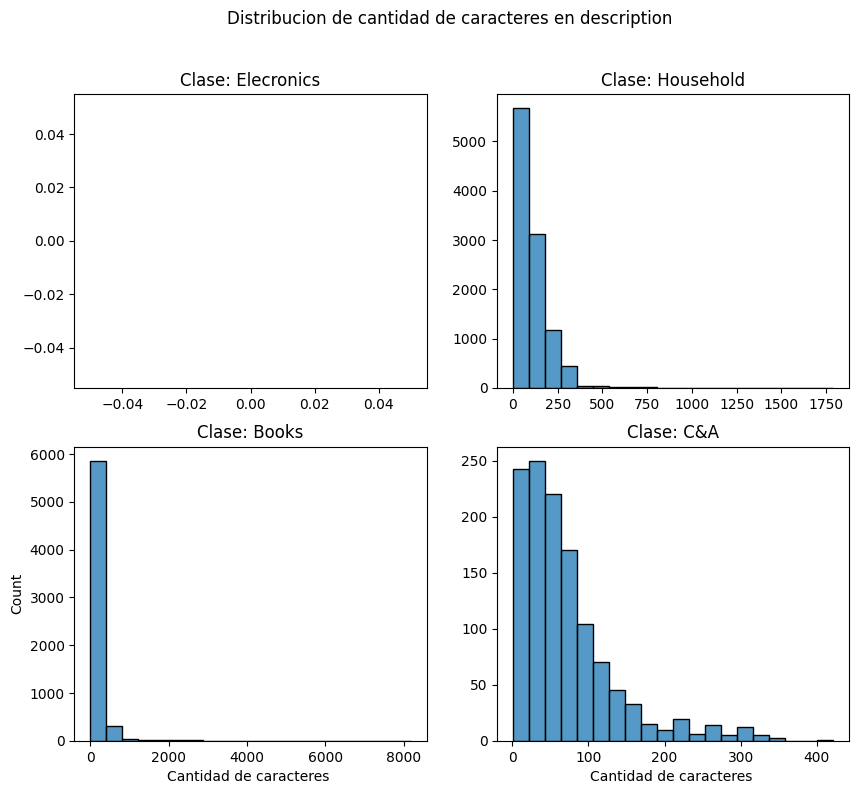

In [13]:
#numero de palabras
data_E_word = data_E['description'].str.split().map(lambda x:len(x))
data_H_word = data_H['description'].str.split().map(lambda x:len(x))
data_B_word = data_B['description'].str.split().map(lambda x:len(x))
data_C_word = data_C['description'].str.split().map(lambda x:len(x))
#se visualiza la contidad de chars
fig,ax=plt.subplots(2,2,figsize = (10,8.4),sharey=False)
sns.histplot(x=data_E_word, bins = 20,ax = ax [0,0]).set_title("Clase: Elecronics")
sns.histplot(x=data_H_word, bins = 20,ax = ax [0,1]).set_title("Clase: Household")
sns.histplot(x=data_B_word, bins = 20,ax = ax [1,0]).set_title("Clase: Books")
sns.histplot(x=data_C_word, bins = 20,ax = ax [1,1]).set_title("Clase: C&A")
#Se itera para graficar la matriz
fig.suptitle("Distribucion de cantidad de caracteres en description")
for i in range(4):
    ax[i//2,i%2].set_xlabel(" ") if i//2 == 0 else ax[i//2,i%2].set_xlabel("Cantidad de caracteres ")
    if i%2 != 0 : ax[i//2,i%2].set_ylabel(" ")

## Laboratorio de Analitica con DataBricks
**Hecho por: Juan Sebastián Clavijo Martínez**<br />
TEMA: Clasificacion de productos electronicos en 4 categorias, basandose en la desc. disp. en las plataformas de comercio electronico: <br />
Electronics, household, books, clothing & Accesories PT.2<br />
### PASOS:<br />
- analisis exploratorio de datos se comparan las distr. del numero de caracteres, en num de palabras y la longitud media de palabras de las descripciones de productos de diferentes categorías <br />
- Normalización de textos: técnicas y desc. de productos <br />
- TF-IDF: Vectorizador en las desc. de productos normalizados para la vectorización de textos se realiza ajuste de hiperparametros para los clasificadores de ML<br />
- Proceso de tratamiento en la conv. minúscula y sustitución de contracciones sobre la desc. de datos en crudo<br />
- <br />
Fecha: 18-09-2023<br />
Notas: 

In [14]:
#se trae el url
url = "https://raw.githubusercontent.com/corredor-john/ExploratoryDataAnalisys/main/Texto/Text_Ecommerce/ecommerce0.csv"
url2 = "https://raw.githubusercontent.com/corredor-john/ExploratoryDataAnalisys/main/Texto/Text_Ecommerce/ecommerce1.csv"
# se hace el DF
datos0 = pd.read_csv(url,names = ['label','description'])
datos1 = pd.read_csv(url2,names = ['label','description'])
#se unen en un solo df
union = [datos0,datos1]
df_texto = pd.concat(union)
df_texto = df_texto[['label','description']]
#se visualiza
df_texto.head()

,label,description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [15]:
##cuenta de datos null, etc.
desaparecidos = len(df_texto)-len(df_texto.dropna())
Cantidad = len(df_texto)
print('Cantidad de obsev. con datos NaN',desaparecidos)
print('Cantidad de datos duplicados', df_texto.duplicated().sum())
##se eliminan los datos Null y Duplicados
df_texto.dropna(inplace=True)
df_texto.drop_duplicates(inplace=True)
#Se reinicia el indice por los elementos eliminados
df_texto.reset_index(drop = True, inplace = True)
df_texto.info()

Cantidad de obsev. con datos NaN 1
Cantidad de datos duplicados 22622
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27802 entries, 0 to 27801
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        27802 non-null  object
 1   description  27802 non-null  object
dtypes: object(2)
memory usage: 434.5+ KB


In [16]:
#columnas
df_texto['label'].unique()


array(['Household', 'Books', 'Clothing & Accessories', 'Electronics'],
      dtype=object)

In [17]:
#cambio de etiquetas
label_dict = {
    'Electronics': 0,
    'Household':1,
    'Books':2,
    'Clothing & Accessories':3
}
df_texto.replace({'label': label_dict}, inplace=True)
print(f"Dimensión del Dataframe: \n{df_texto.shape[0]} registros \n{df_texto.shape[1]} columnas")

Dimensión del Dataframe: 
27802 registros 
2 columnas


In [18]:
##se comprueba la columna 'label'
print(f"Etiquetas de 'label'\n {df_texto['label'].unique()}")

Etiquetas de 'label'
 [1 2 3 0]


In [19]:
#Explorando Data Analisis 
# frecuencia de clases 
# numero de chars
# Numero de palabras
# Promedio de longitud de palabras
# Se divide el conjunto de datos en funcion de las clases, para observar los distintos atributos textuales de las clases


#Se dividen los datos según 'label'
df_texto_E = df_texto[df_texto['label']==0] #electronics
df_texto_H = df_texto[df_texto['label']==1] #Household 
df_texto_B = df_texto[df_texto['label']==2] #Books
df_texto_C = df_texto[df_texto['label']==3] #C&A

In [20]:
##Frecuencia de Clases
valores = np.array([len(df_texto_E), len(df_texto_H),len(df_texto_B), len(df_texto_C)])
labeles = ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
#Se visualiza las clases Ploty
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

figura = go.Figure(data = [go.Pie(values = valores,
                                  labels = labeles,
                                  hole = 0.35, title = " ")])
titulo = "Comparación de frecuencia de clases"
figura.update_layout(height = 450, width = 650, title = titulo)
figura.show()

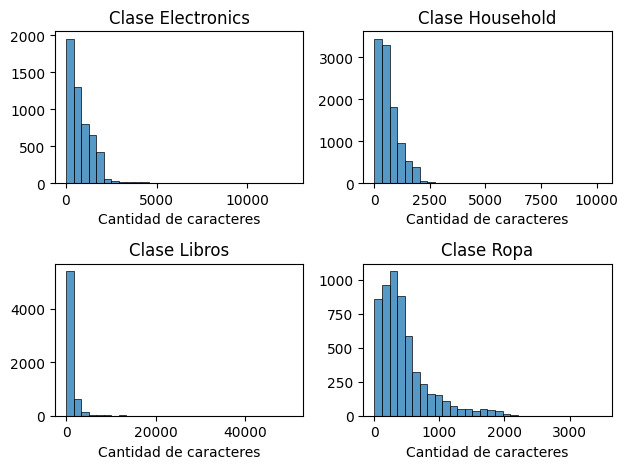

In [21]:
#numero de caracteres
df_texto_E_char = df_texto_E['description'].str.len()
df_texto_H_char = df_texto_H['description'].str.len()
df_texto_B_char = df_texto_B['description'].str.len()
df_texto_C_char = df_texto_C['description'].str.len()
#se visualiza la contidad de chars
fig,ax=plt.subplots(2,2)
sns.histplot(x=df_texto_E_char, bins = 30,ax = ax [0,0])
sns.histplot(x=df_texto_H_char, bins = 30,ax = ax [0,1])
sns.histplot(x=df_texto_B_char, bins = 30,ax = ax [1,0])
sns.histplot(x=df_texto_C_char, bins = 30,ax = ax [1,1])

# Configurar títulos y etiquetas de ejes
ax[0, 0].set_title('Clase Electronics')
ax[0, 0].set_xlabel("Cantidad de caracteres")
ax[0, 0].set_ylabel("")

ax[0, 1].set_title('Clase Household')
ax[0, 1].set_xlabel("Cantidad de caracteres")
ax[0, 1].set_ylabel("")

ax[1, 0].set_title('Clase Libros')
ax[1, 0].set_xlabel("Cantidad de caracteres")
ax[1, 0].set_ylabel("")

ax[1, 1].set_title('Clase Ropa')
ax[1, 1].set_xlabel("Cantidad de caracteres")
ax[1, 1].set_ylabel("")

# Ajustar el espaciado entre subplots
fig.tight_layout()

# Mostrar el gráfico
plt.show()
#Se itera para graficar la matriz
fig.suptitle("Distribucion de cantidad de caracteres en description")
for i in range(4):
    ax[i//2,i%2].set_xlabel(" ") if i//2 == 0 else ax[i//2,i%2].set_xlabel("Cantidad de caracteres ")
    if i%2 != 0 : ax[i//2,i%2].set_ylabel(" ")

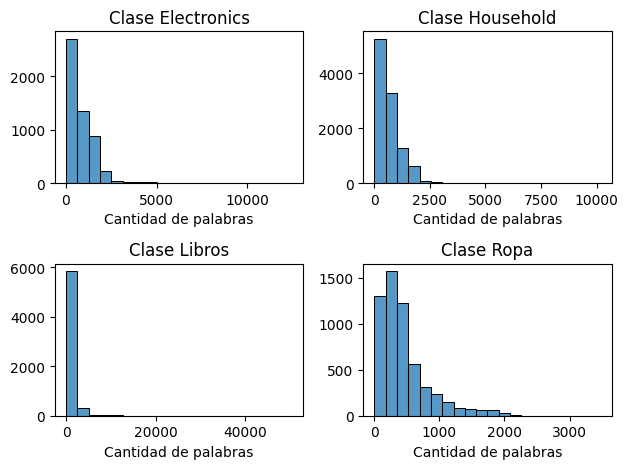

In [22]:
#Cantidad de palabras
df_texto_E_word = df_texto_E['description'].str.split().map(lambda x: len(x)) #la lambda busca palabra, separadas por espacios, calcula la cantidad
df_texto_H_word = df_texto_H['description'].str.split().map(lambda x: len(x))
df_texto_B_word = df_texto_B['description'].str.split().map(lambda x: len(x))
df_texto_C_word = df_texto_C['description'].str.split().map(lambda x: len(x))
#se visualiza la contidad de chars
fig,ax=plt.subplots(2,2)
sns.histplot(x=df_texto_E_char, bins = 20,ax = ax [0,0])
sns.histplot(x=df_texto_H_char, bins = 20,ax = ax [0,1])
sns.histplot(x=df_texto_B_char, bins = 20,ax = ax [1,0])
sns.histplot(x=df_texto_C_char, bins = 20,ax = ax [1,1])

# Configurar títulos y etiquetas de ejes
ax[0, 0].set_title('Clase Electronics')
ax[0, 0].set_xlabel("Cantidad de palabras")
ax[0, 0].set_ylabel("")

ax[0, 1].set_title('Clase Household')
ax[0, 1].set_xlabel("Cantidad de palabras")
ax[0, 1].set_ylabel("")

ax[1, 0].set_title('Clase Libros')
ax[1, 0].set_xlabel("Cantidad de palabras")
ax[1, 0].set_ylabel("")

ax[1, 1].set_title('Clase Ropa')
ax[1, 1].set_xlabel("Cantidad de palabras")
ax[1, 1].set_ylabel("")

# Ajustar el espaciado entre subplots
fig.tight_layout()

# Mostrar el gráfico
plt.show()
#Se itera para graficar la matriz
fig.suptitle("Distribucion de cantidad de caracteres en description")
for i in range(4):
    ax[i//2,i%2].set_xlabel(" ") if i//2 == 0 else ax[i//2,i%2].set_xlabel("Cantidad de caracteres ")
    if i%2 != 0 : ax[i//2,i%2].set_ylabel(" ")

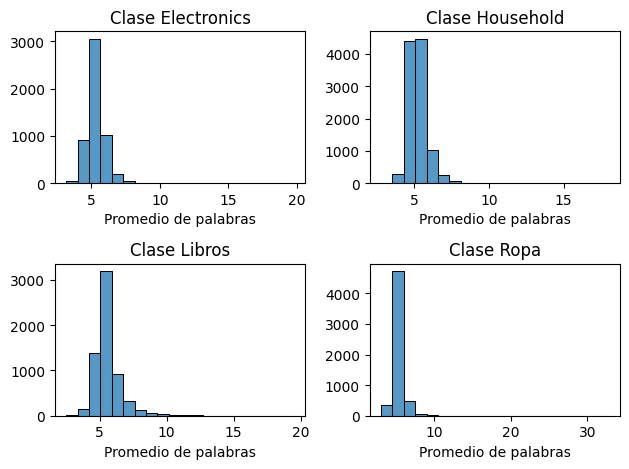

In [23]:
#promedio de palabras
df_texto_E_avg = df_texto_E['description'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x:np.mean(x))
df_texto_H_avg = df_texto_H['description'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x:np.mean(x))
df_texto_B_avg = df_texto_B['description'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x:np.mean(x))
df_texto_C_avg = df_texto_C['description'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x:np.mean(x))
#se visualiza la contidad de chars
fig,ax=plt.subplots(2,2)
sns.histplot(x=df_texto_E_avg, bins = 20,ax = ax [0,0])
sns.histplot(x=df_texto_H_avg, bins = 20,ax = ax [0,1])
sns.histplot(x=df_texto_B_avg, bins = 20,ax = ax [1,0])
sns.histplot(x=df_texto_C_avg, bins = 20,ax = ax [1,1])

# Configurar títulos y etiquetas de ejes
ax[0, 0].set_title('Clase Electronics')
ax[0, 0].set_xlabel("Promedio de palabras")
ax[0, 0].set_ylabel("")

ax[0, 1].set_title('Clase Household')
ax[0, 1].set_xlabel("Promedio de palabras")
ax[0, 1].set_ylabel("")

ax[1, 0].set_title('Clase Libros')
ax[1, 0].set_xlabel("Promedio de palabras")
ax[1, 0].set_ylabel("")

ax[1, 1].set_title('Clase Ropa')
ax[1, 1].set_xlabel("Promedio de palabras")
ax[1, 1].set_ylabel("")

# Ajustar el espaciado entre subplots
fig.tight_layout()

# Mostrar el gráfico
plt.show()
#Se itera para graficar la matriz
fig.suptitle("Distribucion de longitud media de las palabras en description")
for i in range(4):
    ax[i//2,i%2].set_xlabel(" ") if i//2 == 0 else ax[i//2,i%2].set_xlabel("Cantidad de caracteres ")
    if i%2 != 0 : ax[i//2,i%2].set_ylabel(" ")

In [24]:
##grupos de entrenamiento (train) y prueba (test)
#X: variable independiente
#Y: variable dependiente
X, y = df_texto.drop('label', axis=1), df_texto['label']
from sklearn.model_selection import train_test_split

#Se dispone del 20% de los datos para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)
data_train = pd.concat([X_train, y_train], axis=1)

#Se extrae el grupo de validación
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size= 0.50, random_state = 50)
data_val = pd.concat([X_val, y_val], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

##Comparacion de cantidad de grupos test, prueba y validación
valor = np.array([len(data_train), len(data_val), len(data_test)])
etiquetas = ['Training', 'Validation', 'Test']
figura = go.Figure(data = [go.Pie(values = valor, labels=etiquetas, hole=0.35, title=" ")])
titulo = "Comparación de grupos de entrenamiento, prueba y validación"
figura.update_layout(height = 450, width=650, title = titulo)
figura.show()

### Normalizacion de texto: pasos
- Conversion a minusculas 
- Elim. de espacios
- Elim. de puntuaciones
- Elim de UNICODE - Emojis
- Cambio de siglas 
- Cambio de contraccion
- Elim de palabras vacias
- Correccion ortografica
- Stemming y lematizacion
- Conservacion de las partes importantes de la frase (S+V+P)
- Elim de palabras vacias "adicionales"
- Integracion de procesos
- Aplicacion a 'Descrpition'

NLP:Normalizacion de textos es el proceso de transformacion de un texto a una unica forma canonica. El proposito es que las oraaciones/textos se puedan vectorizar para identificarse y hacer operaciones. Es significativo comprender que la metodología ha de combiar e incorporar muchas mas herramientas de reconocimiento de nuvos modismos, entre otros, para este caso en particular, se normalizará sobre la base del inglés, es mas facil que hacerlo en castellano

In [25]:
###RegexTokenizer: Division de cadenas en subcadenas con un patrón
from nltk.tokenize import RegexpTokenizer
regexp = RegexpTokenizer("[\w]+")
regexp

<>:3: SyntaxWarning:

invalid escape sequence '\w'

<>:3: SyntaxWarning:

invalid escape sequence '\w'

C:\Users\juanc\AppData\Local\Temp\ipykernel_7608\408151629.py:3: SyntaxWarning:

invalid escape sequence '\w'



RegexpTokenizer(pattern='[\\w]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)

## Conversion a minusculas 

Todos los carcteres alfanumericos a minusculas: El modelo NO debe diferenciar palabras minusculas y mayusc. como diferentes

In [26]:
def conversion_minusculas(texto):
    return texto.lower()
#verificacion: 

##Elim. espacios en blanco

whitespaces innecesarios

In [27]:
def rmwsp(texto):
    return texto.strip()

In [28]:
print("Hello world")

Hello world
